In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import h5py
import matplotlib.pyplot as plt
from dolfin import *

1. Implement the basics of the pulsating poiseuille flow within this notebook.
2. Implement ability to read mixed element function spaces from pickled info.
3. Separate conversion of hdf5 into xdmf as a separate function.
4. Implement splitting functionality to the xdmf visualization converter. Note that calling `u.split()` on a non-splittable function returns an empty set.

# Define Poiseuille Flow Problem

In [6]:
from pantarei.elements import TaylorHood
from pantarei.meshprocessing import hdf2fenics
from pantarei.io import TimeSeriesStorage

In [20]:
mesh, subdomains, boundaries = hdf2fenics("../examples/pipe2d.h5")
TH = TaylorHood(mesh)
W = FunctionSpace(mesh, TH)
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
n = FacetNormal(mesh)

# Pulsating Pressure
p_inflow = Expression("10. * sin(t) + 5. * sin(3.*t)",
                      t=Constant(1.), degree=1)
p_outflow = Constant(0.)


ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
F = (inner(grad(u), grad(v)) - p*div(v) - q*div(u)) * dx \
    + inner(p_inflow * n, v) * ds(4) + inner(p_outflow * n, v) * ds(2)

bcs = [
    DirichletBC(W.sub(0), Constant((0., 0.)), boundaries, 1),
    DirichletBC(W.sub(0), Constant((0., 0.)), boundaries, 3)
]

storage = TimeSeriesStorage("w", "./tsstorage", mesh=mesh, V=W)

a, L = lhs(F), rhs(F)
UP = Function(W)

t = 0.
T = 10.
dt = 0.1
set_log_level(20)
storage.write(UP, t)
while t < T:
    t += dt
    solve(a == L, UP, bcs)
    p_inflow.t.assign(t)
    storage.write(UP, t)
    
storage.to_xdmf(("u", "p"))
storage.close()
# visual = TimeSeriesStorage("r", "./tsstorage")
# visual.to_xdmf((("velocitx", "velocity"), "pressure"))
# visual.close()

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

In [18]:
visual = TimeSeriesStorage("r", "./tsstorage")
visual.to_xdmf((("velocitx", "velocity"), "pressure"))
visual.close()

In [14]:
visual.close()

In [15]:
visual = TimeSeriesStorage("r", "./tsstorage")

In [20]:
u = Function(visual.V)
hdf5 = HDF5File(visual.mesh.mpi_comm(), "tsstorage/values.hdf5", "r")
for i in range(len(visual)):
    hdf5.read(u.vector(), f"/values_{i}", True)

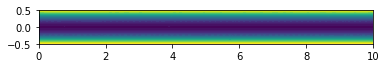

In [9]:
plot(UP.split()[0].split()[0])

In [31]:
u

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 2072), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2)), 3165)

In [12]:
visual = TimeSeriesStorage("r", "./tsstorage")
visual.to_xdmf(("velocity", "pressure"))

velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
pressure
velocity
p

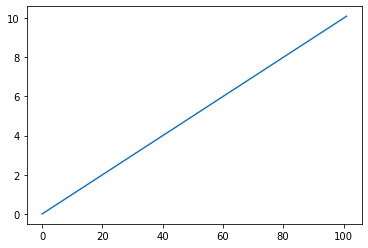

In [31]:
plt.plot(visual.times)

In [15]:
UP.split()

(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 3134), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2)), 5201),
 Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 3134), FiniteElement('Lagrange', triangle, 1)), 5202))

In [18]:
ux, uy = u.split()

In [19]:
ux.split()

()

In [14]:
u.split()

(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 3134), FiniteElement('Lagrange', triangle, 2)), 5199),
 Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 3134), FiniteElement('Lagrange', triangle, 2)), 5200))

In [4]:
import pickle
import numpy as np
import osv
from pathlib import Path
from dolfin import HDF5File, XDMFFile, FunctionSpace, Function, Mesh


class TimeSeriesStorage:
    """ TODO:
            * Add a name-tag for functions
            * Initialize from function, and get mesh and functionspace from there
            * Consider a switch for turning off xdmf-storage if not needed.
    """
    def __init__(self, mode: str, filepath, *, mesh=None, V=None):
        self.filepath = Path(filepath).resolve()
        if mode == "w":
            assert (mesh is not None and V is not None), 'mode "w" requires a mesh and functionspace V.'
            self._init_write(mesh, V)
        elif mode == "r":
            self._init_read()
        else:
            raise ValueError(f"Invalid mode '{mode}'. Shold be 'w' (write) or 'r' (read).")

    def _init_write(self, mesh, V):
        self.mesh = mesh
        self.V = V

        # Create directory, value-file and xdmf file for paraview visualization.
        self.filepath.mkdir(exist_ok=True)

        hdffile, xdmffile, infofile = (self.filepath / file for file in ("values.hdf5", "visual.xdmf", "info.pkl"))
        for file in (hdffile, xdmffile, infofile):
            if file.exists():
                os.remove(file)

        self.hdf5 = HDF5File(mesh.mpi_comm(), str(hdffile), "w")
        self.xdmf = XDMFFile(mesh.mpi_comm(), str(xdmffile))

        # Store the mesh to file for simple reconstruction of functionspace.
        with HDF5File(mesh.mpi_comm(), str(self.filepath / "mesh.hdf5"), "w") as f:
            f.write(mesh, "/mesh")

        # Initialize time and length
        self.idx = 0
        self.times = np.empty(0)

    def _init_read(self):
        assert self.filepath.is_dir(), f"filepath {self.filepath} does not exist."

        # Load mesh from stored file.
        self.mesh = Mesh()
        with HDF5File(self.mesh.mpi_comm(), str(self.filepath / "mesh.hdf5"), "r") as f:
            f.read(self.mesh, "/mesh", True)

        # Open file to read values
        self.hdf5 = HDF5File(self.mesh.mpi_comm(), str(self.filepath / f"values.hdf5"), "r")

        # Reconstruct functionspace, and create function to load values.
        self.times, el = self.load_info()

        self.V = FunctionSpace(self.mesh, el)
        self.u = Function(self.V)

        # Find the number of elements written to file, to determine length.
        self.idx = self.times.size

    def load_mesh(self):
        # Load mesh from stored file.
        self.mesh = Mesh()
        with HDF5File(self.mesh.mpi_comm(), str(self.filepath / "mesh.hdf5"), "r") as f:
            f.read(self.mesh, "/mesh", True)
        return self.mesh

    def _extend_time_vector(self):
        self.times = np.concatenate((self.times, np.nan * np.empty(100)))

    def write(self, u, t):
        # Attempt to preallocate data
        try:
            self.times[self.idx] = t
        except IndexError:
            self._extend_time_vector()
            self.times[self.idx] = t
        # Store data
        self.hdf5.write(u.vector(), f"/values_{self.idx}")
        self.xdmf.write(u, t)
        self.idx += 1

    def store_info(self):
        with open(self.filepath / "info.pkl", "wb") as f:
            pickle.dump((self.times[~np.isnan(self.times)], self.V.ufl_element()), f)

    def load_info(self):
        with open(self.filepath / "info.pkl", "rb") as f:
            times, el = pickle.load(f)
        return times, el

    def close(self):
        if hasattr(self, 'hdf5'):
            self.hdf5.close()
        if hasattr(self, 'xdmf'):
            self.xdmf.close()
        self.store_info()

    def __iter__(self):
        for i in range(len(self)):
            # u = Function(self.V)

            self.hdf5.read(self.u.vector(), f"/values_{i}", True)
            yield self.u

    def dual_iter(self):
        for i in range(len(self)):
            self.hdf5.read(self.u.vector(), f"/values_{i}", True)
            yield self.times[i], self.u

    def __len__(self):
        return self.idx
